In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

from PIL import Image
from torchvision import transforms

In [3]:
import albumentations as A
from albumentations import (Compose, HorizontalFlip, ShiftScaleRotate, OpticalDistortion,
                            RGBShift, Blur, RandomBrightness, GridDistortion, 
                            Cutout, OneOf, GaussNoise, Resize)
from albumentations.pytorch import ToTensor

In [3]:
from resnet_model import Bottleneck, ResNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

from PIL import Image

In [41]:
reg_transforms = torchvision.transforms.Compose([
    transforms.Resize(size=(256,256)),
    # transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

aug_pipeline = Compose([
            HorizontalFlip(p=0.25),

            OneOf([RGBShift(p=1.0),
                   RandomBrightness(p=1.0, limit=0.35),
                   Blur(p=1.0, blur_limit=4),
                   OpticalDistortion(p=1.0),
                   GridDistortion(p=1.0),
                   GaussNoise(p=1.0)], p=0.25),
            Cutout(num_holes=2, max_h_size=25, max_w_size=20,
                   p=0.25),
            ToTensor()
        ])


class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, scene_index, reg_transform, aug_transform, train = True):
        self.image_folder = image_folder
        self.scene_index = scene_index
        self.reg_transform = reg_transform
        self.aug_transform = aug_transform
        
        self.first_dim = 'image'
        self.is_training = train
        
        if not self.is_training:
            np.random.seed(1008)
        
    
    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
    
    def __getitem__(self, index):
        scene_id = self.scene_index[index//(NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
        sample_id = (index % (NUM_SAMPLE_PER_SCENE*NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
        image_name = image_names[index % NUM_IMAGE_PER_SAMPLE]
        
        image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 
            
        image = Image.open(image_path)

        if self.is_training:
            rotation = index %4 # fixed rotation for training data
        else:
            rotation = np.random.randint(0,4)
            
        image = self.reg_transform(image)
        image = image.rotate(rotation * 90)
        
        if not self.is_training:#if not training, no augmentation
            val_transform = transforms.ToTensor()
            image = val_transform(image)
            return image, rotation
        
        image = np.array(image)
        augmented = self.aug_transform(image=image)
        image = augmented['image']
        
        return image, rotation

In [44]:
BATCH_SIZE=32
random.seed(1008)
random.shuffle(unlabeled_scene_index)
train_scene = unlabeled_scene_index[:85]
val_scene = unlabeled_scene_index[85:]

train_set = AugmentedDataset(image_folder = image_folder,
                                  scene_index = train_scene,
                                  reg_transform = reg_transforms, aug_transform = aug_pipeline, 
                                  train=True)
val_set = AugmentedDataset(image_folder = image_folder,
                                  scene_index = val_scene,
                                  reg_transform = reg_transforms, aug_transform = aug_pipeline, 
                                  train=False)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers =2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers =2)

In [45]:
data, target = iter(train_loader).next()

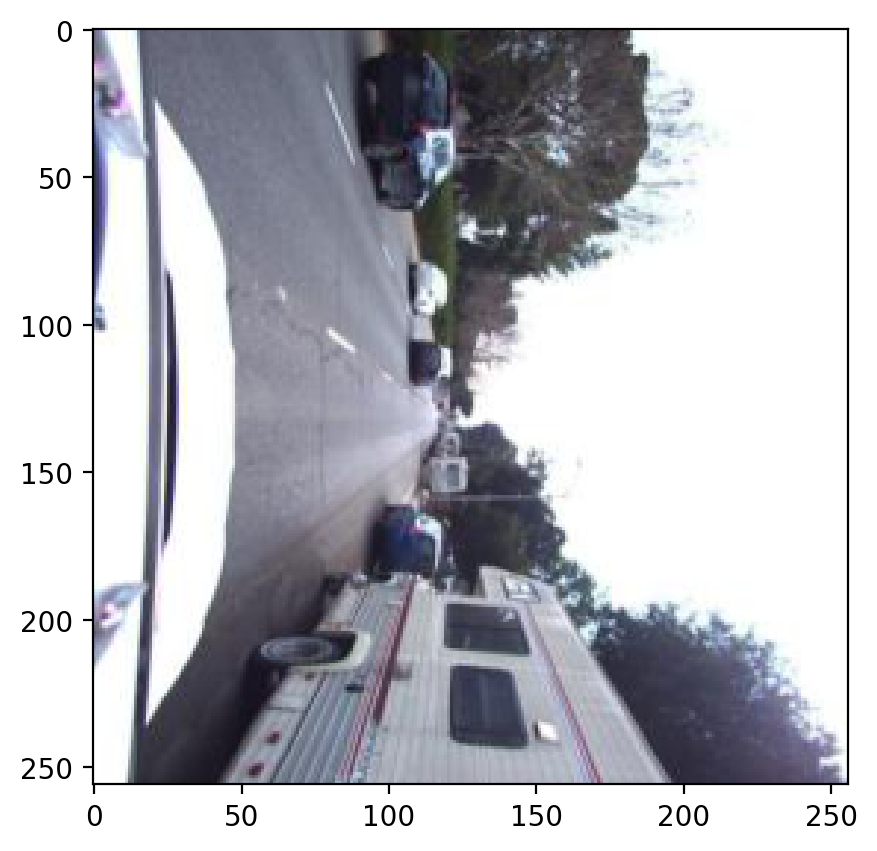

tensor([3])


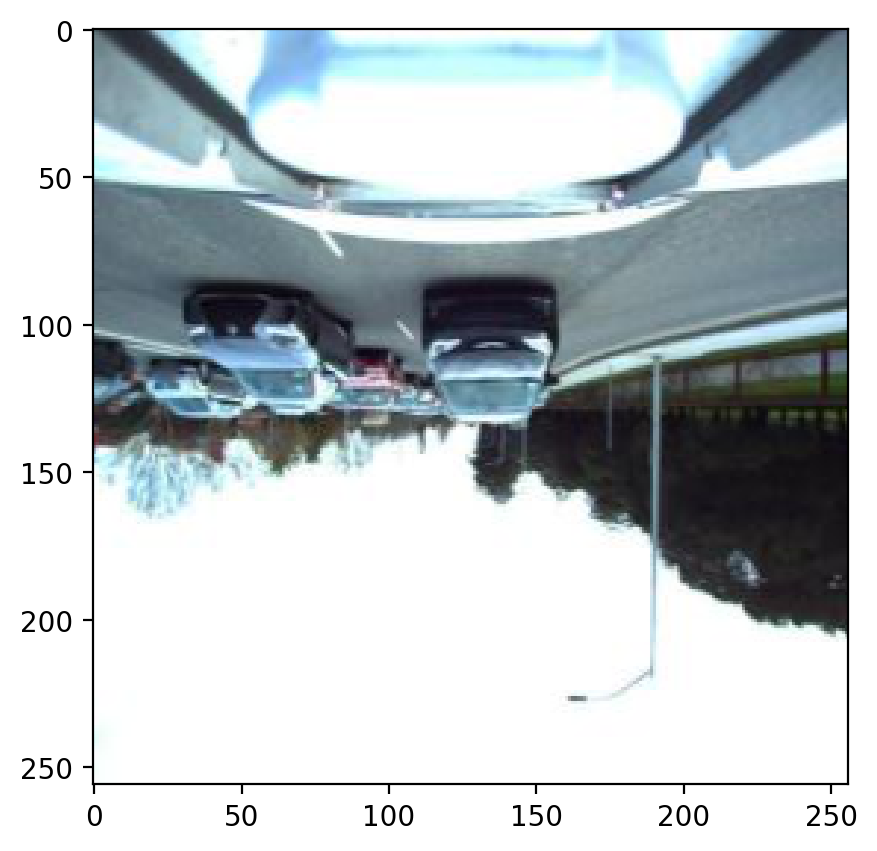

tensor([2])


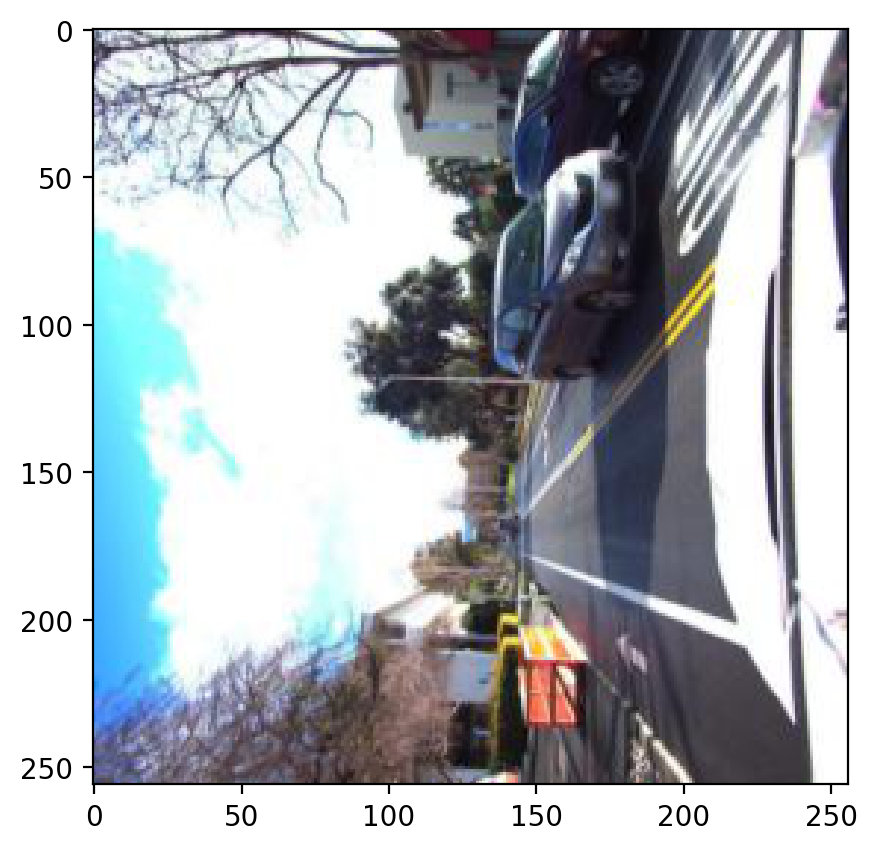

tensor([3])


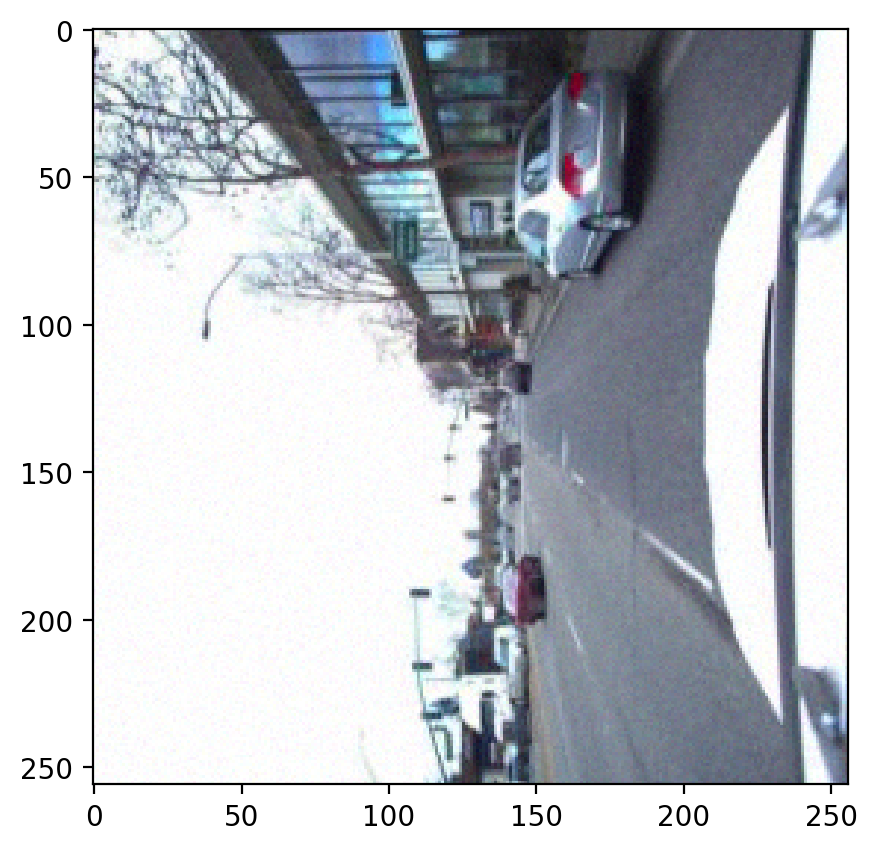

tensor([1])


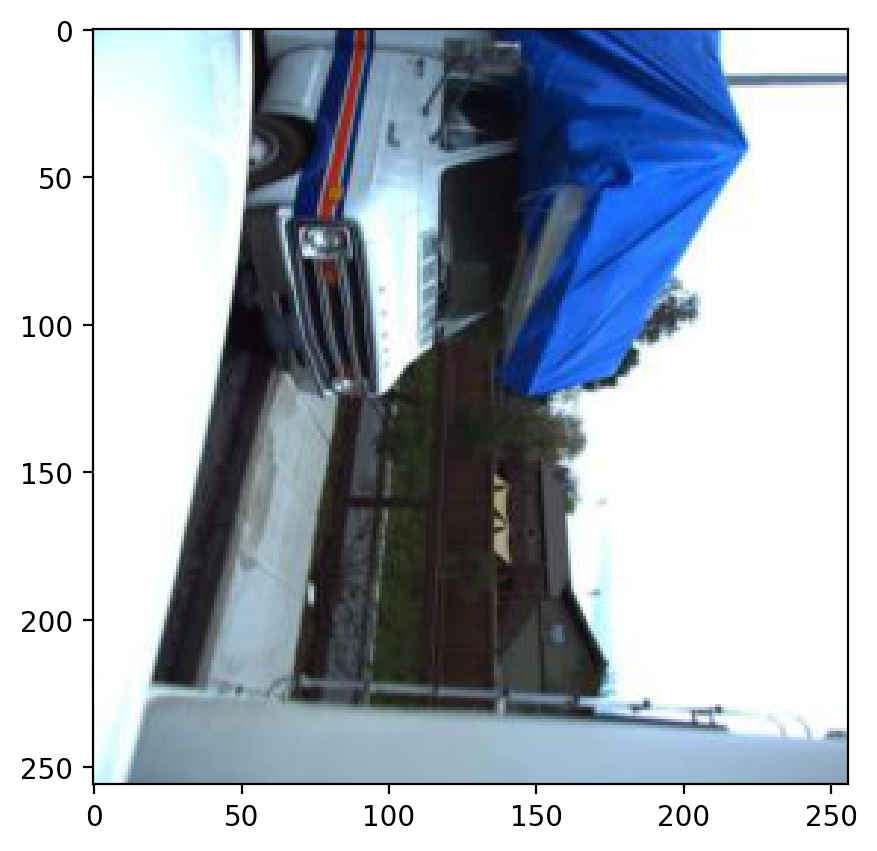

tensor([1])


In [43]:
for i, (data, target) in enumerate(train_loader):
    plt.imshow(data[0].numpy().transpose(1,2,0))
    plt.show()
    print(target)
    if i == 4:
        break

In [47]:
mini_set, _ = torch.utils.data.random_split(train_set, [5, len(train_set) - 5])
mini_val, _ = torch.utils.data.random_split(val_set, [3, len(val_set)-3])

mini_loader = torch.utils.data.DataLoader(mini_set, batch_size = 1, 
                                          shuffle = True, num_workers = 2, 
                                          )

mini_val_loader = torch.utils.data.DataLoader(mini_val, batch_size = 1, 
                                          shuffle = True, num_workers = 2, 
                                          )



In [48]:
def tarin_eval_model(model, train_loader, val_loader, criterion, optimizer, 
                     scheduler, num_epochs, checkpoint_file, to_save_path, 
                     eval_every = 1):
    model.train()
    
    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_acc = checkpoint['best_acc']
    else: 
        best_acc = 0.0
    
    
    start_time =time.time()
    
    loss_dict = {'train':[], 'val':[]}
    acc_list = []
    curr_iteration = 0
    curr_loss = 0.0
    
    for epoch in range(num_epochs):
        
        
        epoch_start  = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        # print('len(train_loader)', len(train_loader.dataset))
        for i, (sample, target) in enumerate(train_loader):

            
            sample = sample.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            outputs = model(sample)
            
            loss = criterion(outputs, target)
            
            curr_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            curr_iteration +=1
        

            if curr_iteration % eval_every == 0:
                curr_loss/=(curr_iteration*BATCH_SIZE)
                loss_dict['train'].append(curr_loss)
        
                print('current training loss is %f'%(curr_loss))
                print('training iteration %d takes %f'%(curr_iteration, time.time() - epoch_start))
                curr_loss = 0.0
            
                # print('len(val_loader)', len(val_loader.dataset))
                val_start = time.time()
                model.eval()
                val_loss = 0.0
                curr_acc = 0.0
                total = 0
                correct = 0
                with torch.no_grad():
                    for i, (sample, target) in enumerate(val_loader):
                        sample = sample.to(device)
                        target = target.to(device)
                        
                        outputs = model(sample)
                        loss = criterion(outputs, target)
                        val_loss += loss.item()

                        _, predicted = torch.max(outputs.data, dim=1)
                        total += target.size(0)
                        correct += (predicted == target).sum().item()

                curr_acc = correct/total
                loss_dict['val'].append(val_loss/total)

                acc_list.append(curr_acc)
                scheduler.step(curr_acc)

                print('Current validation loss is %f' %(val_loss/total))
                print('Current validation accuracy is %f'%(curr_acc))
                print('current val takes', time.time() - val_start)

                if curr_acc > best_acc:
                    print('saving best model')
                    best_acc = curr_acc
                    checkpoint = {'model': model.state_dict(), 
                                  'optimizer': optimizer.state_dict(), 
                                  'best_acc': best_acc}
                    torch.save(checkpoint, to_save_path)

                model.train()
                

    for key in list(loss_dict.keys()):
        if len(loss_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(loss_dict[key])
            plt.title('%s loss per epoch'%(key))
            plt.show()
            
    if len(acc_list) > 0:
        plt.plot(acc_list)
        plt.title('accuracy_list')
        plt.show()
    
    return model, loss_dict, acc_list




In [55]:
my_model = ResNet(Bottleneck, [3, 4, 6, 3],num_classes=4)
my_model = my_model.to(device)

In [52]:
import time

Epoch 1/5
----------
current training loss is 0.012513
training iteration 500 takes 406.815462
Current validation loss is 0.010588
Current validation accuracy is 0.840829
current val takes 143.13379573822021
saving best model
current training loss is 0.003768
training iteration 1000 takes 956.206983
Current validation loss is 0.017381
Current validation accuracy is 0.789368
current val takes 138.63263750076294
current training loss is 0.001911
training iteration 1500 takes 1501.454749
Current validation loss is 0.010917
Current validation accuracy is 0.847821
current val takes 141.90754461288452
saving best model
current training loss is 0.001024
training iteration 2000 takes 2049.912958
Current validation loss is 0.010229
Current validation accuracy is 0.855946
current val takes 138.89303135871887
saving best model
Epoch 2/5
----------
current training loss is 0.000696
training iteration 2500 takes 399.658358
Current validation loss is 0.008518
Current validation accuracy is 0.881078


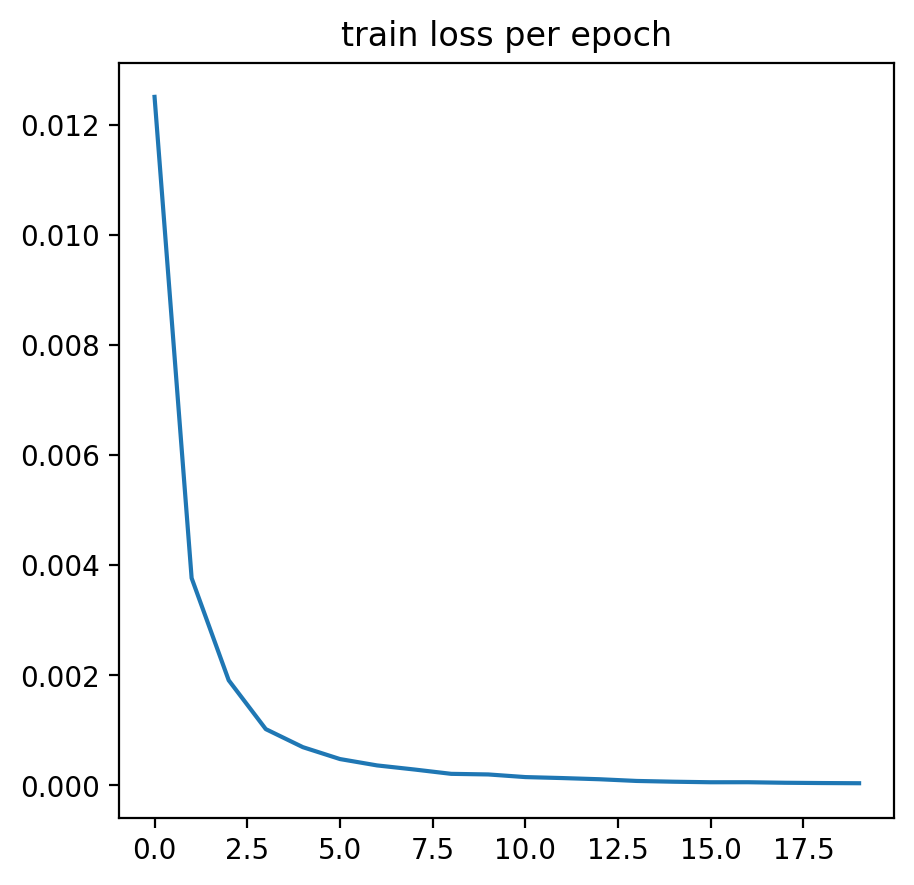

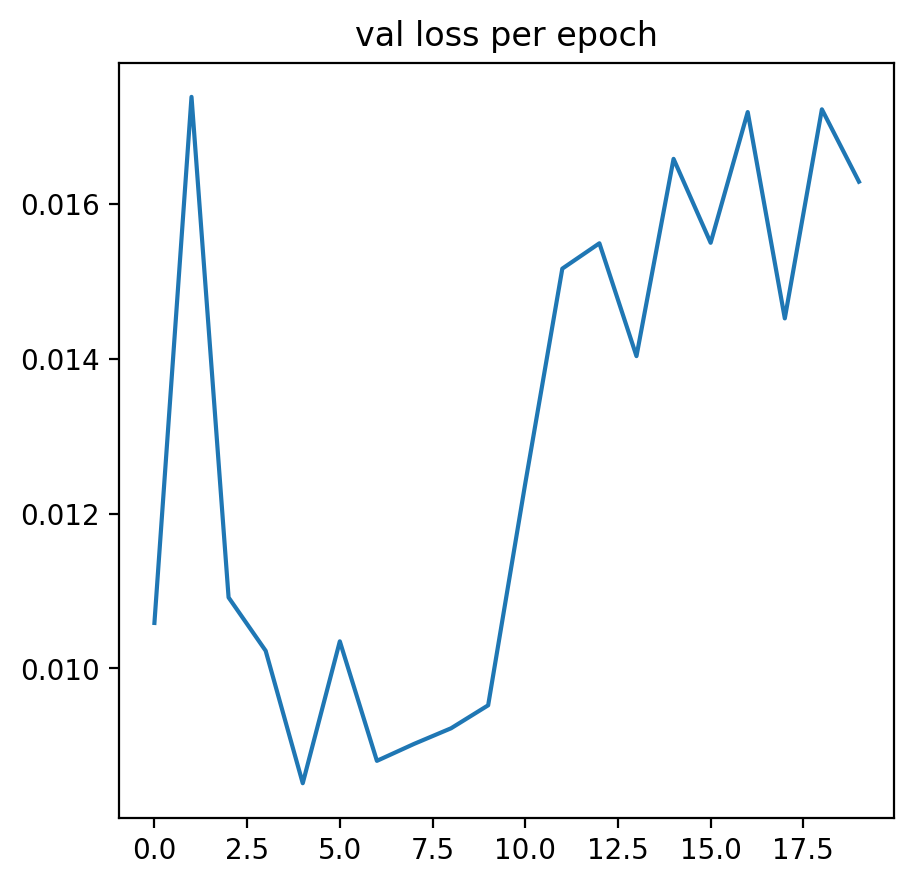

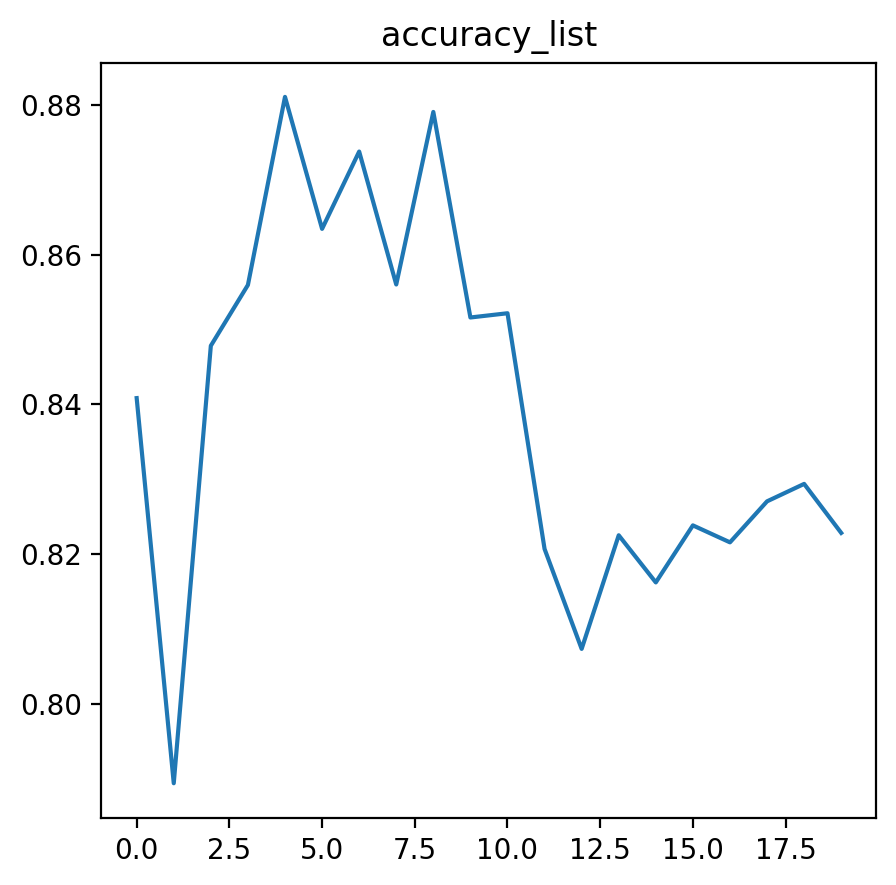

In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True)

model, loss_dict, acc_list = tarin_eval_model(my_model, train_loader, 
                                              val_loader, criterion, optimizer, 
                                              scheduler, num_epochs=5, checkpoint_file=None, 
                                              to_save_path = '/scratch/ht1162/DLResult/pretrain_rotation_aug.pth', 
                     eval_every = 500)



In [ ]:
best_checkpoint

## here we use the pretrained weights on training the resnet50

In [2]:
def dice_loss(true, preds, epsilon = 1e-4):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon
    loss = 1 - 2*(num/denom)

    return torch.mean(loss)

def dice_loss2(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)


def compute_dice(true, preds, epsilon = 1e-7):
    #sh1, sh2 = preds.size()
    true = true.view(1, -1)
    preds = preds.view(1, -1)
    
    prod = torch.sum(true*preds,dim = 1)
    sum_tnp = torch.sum(true + preds, dim = 1)
    
    num = torch.sum(prod)
    denom = torch.sum(sum_tnp) + epsilon

    return torch.mean(num/denom)

def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [5]:
labeled_scene_index = np.arange(106, 134)
random.seed(1008)
random.shuffle(labeled_scene_index)
train_idx = labeled_scene_index[:22]
val_idx = labeled_scene_index[22:26]
test_idx = labeled_scene_index[26:]


transform = torchvision.transforms.Compose([
    # transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(img_net_mean.tolist(), img_net_std.tolist())
])

BATCH_SIZE=1

train_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = train_idx,
                                  transform = transform, 
                                  extra_info = True)

val_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = val_idx,
                                  transform = transform, 
                                  extra_info = True)




train_loader = torch.utils.data.DataLoader(train_set, batch_size =BATCH_SIZE, 
                                           shuffle = True, num_workers =2, 
                                           collate_fn = collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, 
                                         shuffle = True, num_workers =2, 
                                         collate_fn = collate_fn)
test_set = LabeledDataset(image_folder = image_folder,
                                  annotation_file = annotation_csv,
                                  scene_index = test_idx,
                                  transform = transform, 
                                  extra_info = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, 
                                          shuffle=True, num_workers=2, 
                                          collate_fn=collate_fn)

In [6]:


class _DecoderBlock(nn.Module):
    """
    Taken from https://github.com/zijundeng/pytorch-semantic-segmentation/blob/master/models/seg_net.py
    """
    def __init__(self, in_channels, out_channels, num_conv_layers, out_activation = 'relu'):
        super(_DecoderBlock, self).__init__()
        middle_channels = int(in_channels / 2)
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ]
        layers += [
                      nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
                      nn.BatchNorm2d(middle_channels),
                      nn.ReLU(inplace=True),
                  ] * (num_conv_layers - 2)
        layers += [
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)
    
class _SameDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, out_activation = 'relu'):
        super(_SameDecoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=3),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        layers += [
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) if out_activation == 'relu' else nn.Sigmoid(),
        ]
        self.decode = nn.Sequential(*layers)

    def forward(self, x):
        return self.decode(x)

# pyramid style decoder:
class PPMBilinear(nn.Module):
    def __init__(self, num_class=1, fc_dim=256,
                 pool_scales=(1, 2, 3, 6), out_size=800):
        super(PPMBilinear, self).__init__()
        self.out_size = out_size
        self.ppm = [nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                    nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                    nn.ReLU(inplace=True))]
        for scale in pool_scales[1:]:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale), 
                            nn.Conv2d(fc_dim, 256, kernel_size=1, bias= False), 
                            nn.BatchNorm2d(256), 
                            nn.ReLU(inplace=True)))
        self.ppm = nn.ModuleList(self.ppm)

        self.pool_conv = nn.Sequential(
            nn.Conv2d(fc_dim+len(pool_scales)*256, 256,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, num_class, kernel_size=1)
        )
        self.conv_last = nn.Sequential(*[_SameDecoder(256, 256), 
                                         _DecoderBlock(256, 128, 2),
                                         _DecoderBlock(128, 64, 2), 
                                         _DecoderBlock(64, 32, 2), 
                                         _DecoderBlock(32, 1, 2, 'Sigmoid')])
        
        # self.sigmoid = nn.Sigmoid()
    def forward(self, conv_out):
        conv5 = conv_out[-1]

        input_size = conv5.size()
             
        ppm_out = [conv5]
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(
                pool_scale(conv5),
                (input_size[2], input_size[3]),
                mode='bilinear', align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)
        # print(ppm_out.shape)
        x = self.pool_conv(ppm_out)
        #feat = x
        x  =self.conv_last(x)
        # print(x.shape)
        x = nn.functional.interpolate(x, (self.out_size,self.out_size), mode='bilinear', align_corners = False)
        
        return x

class TransformModule(nn.Module):
    '''
    Modified from https://github.com/pbw-Berwin/View-Parsing-Network/blob/dc0c4250302b84a8594f291a494b5e8969291e1b/segmentTool/models.py
    '''
    def __init__(self, dim1, dim2, num_view = 6):
        super(TransformModule, self).__init__()
        self.num_view = num_view
        self.dim1 = dim1
        self.dim2 = dim2
        self.mat_list = nn.ModuleList()
        
        for i in range(self.num_view):
            # weights are not shared
            fc_transform = nn.Sequential(
                        nn.Linear(dim1* dim2, dim1*dim2*4), 
                        nn.ReLU(), 
                        nn.Linear(dim1 * dim2*4, dim1*dim2),
                        nn.ReLU()
            )
            self.mat_list += [fc_transform]
    
    def forward(self, x):
        # shape B V C H W
        # flatten along the channel
        x = x.view(list(x.size()[:3]) + [self.dim1 * self.dim2,])
        # Transform the first image
        view_comb = self.mat_list[0](x[:, 0])
        for i in range(1, x.size(1)):
            # results are added(fusion func)
            view_comb += self.mat_list[i](x[:, i])
        view_comb = view_comb.view(list(view_comb.size()[:2]) + [self.dim1, self.dim2]) 
        return view_comb
        

class vpn_model(nn.Module):
    def __init__(self, dim1, dim2, encoder, decoder):
        super(vpn_model, self).__init__()
        self.num_views = 6
        self.encoder = encoder
        
        self.transform = TransformModule(dim1=dim1, dim2=dim2)
        
        self.decoder = decoder
        
        
    def forward(self, x, return_feat = False):
        # flatten the output along channel: C x (HW)
        # weights are not shared, i.e. each first view input has
        # own VRM to get its top down view feature map 
        # i here in range 6(MN, N=6,M=1(MODALITY))
        # j here in range num_channels
        # 
        B,V,C,H,W = x.shape
        x = x.view(B*V, C, H, W)
        x = self.encoder(x)
        # return to B V 
        x = x.view([B,V] + list(x.size()[1:]))
        x =  self.transform(x) # B x c x h x w
        
        x = self.decoder([x])

        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
pretrain_checkpoint = torch.load('/scratch/ht1162/DLResult/pretrain_rotation_aug.pth')

encoder = ResNet(Bottleneck, [3, 4, 6, 3],num_classes=4)
encoder.load_state_dict(pretrain_checkpoint['model'])

encoder = list(encoder.children())[:-3]
encoder = nn.Sequential(*encoder)
for param in encoder.parameters():
    param.requires_grad = True
    
decoder = PPMBilinear(fc_dim=1024)
DIM1=  16
DIM2=20
my_model = vpn_model(DIM1, DIM2, encoder, decoder).to(device)

In [95]:
data, target, roadmap, extra = iter(val_loader).next()

In [9]:
def tarin_eval_model(model, train_loader, val_loader, criterion, optimizer, 
                     scheduler, num_epochs, checkpoint_file, to_save_path, 
                     batch_size,
                     eval_every = 1000):
    model.train()
    
    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_ts = checkpoint['best_ts']
        print('loading previous weights success')
    else: 
        best_ts = 0.0
    
    
    start_time =time.time()
    
    loss_dict = {'train':[], 'val':[]}
    dice_dict = {'train':[], 'val':[]}

    ts_list = []
    
    curr_iteration = 0
    curr_loss = 0.0
    curr_dice = 0.0
    
    for epoch in range(num_epochs):
        
        train_start  = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        # print('len(train_loader)', len(train_loader.dataset))
        for _, (sample, _, roadmap, _) in enumerate(train_loader):
            sample = torch.stack(sample).to(device)
            target = torch.stack(roadmap).to(device)            

            optimizer.zero_grad()
            outputs = model(sample)
            
            loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
            with torch.no_grad():
                dice = compute_dice(target.cpu(), outputs.cpu().squeeze(1))

            curr_loss += loss.item()
            curr_dice += dice
            
            loss.backward()
            optimizer.step()
            
            curr_iteration +=1
        

            if curr_iteration % eval_every == 0:
                # print(curr_iteration)
                curr_loss/=(curr_iteration*batch_size)
                curr_dice/=(curr_iteration*batch_size)
                
                loss_dict['train'].append(curr_loss)
                dice_dict['train'].append(curr_dice)
        
                print('current training loss is %f'%(curr_loss))
                print('current training dice is %f'%(curr_dice))
                print('training iteration %d takes %f'%(curr_iteration, time.time() - train_start))
                train_start = time.time()
                curr_loss = 0.0
                curr_dice = 0.0
            
                # print('len(val_loader)', len(val_loader.dataset))
                val_start = time.time()
                model.eval()
                
                val_loss = 0.0
                val_dice = 0.0
                curr_ts = 0.0
                total = 0

                with torch.no_grad():
                    for j, (sample, target, roadmap, extra) in enumerate(val_loader):
                        sample = torch.stack(sample).to(device)
                        target = torch.stack(roadmap).to(device)
                        
                        outputs = model(sample)
                        loss = criterion(target.cpu(), outputs.cpu().squeeze(1))
                        dice = compute_dice(target.cpu(), outputs.cpu().squeeze(1))
                        val_loss += loss.item()
                        val_dice += dice
                        curr_ts += compute_ts_road_map(target.cpu(), outputs.cpu().squeeze(1))

                        total += target.size(0)

                curr_ts /= total
                loss_dict['val'].append(val_loss/total)
                dice_dict['val'].append(val_dice/total)
                ts_list.append(curr_ts)
                scheduler.step(curr_ts)

                print('Current validation loss is %f' %(val_loss/total))
                print('Current validation dice is %f'%(val_dice/total))
                print('Current validation ts is %f'%(curr_ts))
                print('current val takes', time.time() - val_start)
                val_start = time.time()

                if curr_ts > best_ts:
                    print('saving best model')
                    best_ts = curr_ts
                    checkpoint = {'model': model.state_dict(), 
                                  'optimizer': optimizer.state_dict(), 
                                  'best_ts': curr_ts}
                    torch.save(checkpoint, to_save_path)

                model.train()
                

    for key in list(loss_dict.keys()):
        if len(loss_dict[key]) > 0:
            fig = plt.figure()
            plt.plot(loss_dict[key])
            plt.title('%s loss per epoch'%(key))
            plt.show()
            
    for key in list(dice_dict.keys()):
        if len(dice_dict[key])>0:
            fig = plt.figure()
            plt.plot(dice_dict[key])
            plt.title('%s dice coef per epoch'%(key))
            plt.show()

        
    if len(ts_list) > 0:
        plt.plot(ts_list)
        plt.title('ts_list')
        plt.show()
    
    return model, loss_dict, dice_dict, ts_list


In [11]:
import time

Epoch 1/5
----------
current training loss is 0.376447
current training dice is 0.311776
training iteration 300 takes 40.862655
Current validation loss is 0.387479
Current validation dice is 0.306261
Current validation ts is 0.446433
current val takes 32.57755661010742
saving best model
current training loss is 0.185648
current training dice is 0.157176
training iteration 600 takes 79.455187
Current validation loss is 0.389665
Current validation dice is 0.305167
Current validation ts is 0.444111
current val takes 34.58773493766785
current training loss is 0.119152
current training dice is 0.107091
training iteration 900 takes 79.997276
Current validation loss is 0.444645
Current validation dice is 0.277678
Current validation ts is 0.387984
current val takes 38.70539093017578
current training loss is 0.087545
current training dice is 0.081227
training iteration 1200 takes 87.334836
Current validation loss is 0.375110
Current validation dice is 0.312445
Current validation ts is 0.460158


Current validation loss is 0.294845
Current validation dice is 0.352577
Current validation ts is 0.555975
current val takes 31.141942024230957
current training loss is 0.005633
current training dice is 0.012335
training iteration 9900 takes 70.859640
Current validation loss is 0.268156
Current validation dice is 0.365922
Current validation ts is 0.589652
current val takes 36.395100831985474
saving best model
current training loss is 0.005495
current training dice is 0.011958
training iteration 10200 takes 76.839392
Current validation loss is 0.280939
Current validation dice is 0.359530
Current validation ts is 0.574040
current val takes 32.201210260391235
current training loss is 0.005142
current training dice is 0.011715
training iteration 10500 takes 72.045338
Current validation loss is 0.273489
Current validation dice is 0.363256
Current validation ts is 0.583460
current val takes 34.19690132141113
current training loss is 0.004831
current training dice is 0.011473
training iteratio

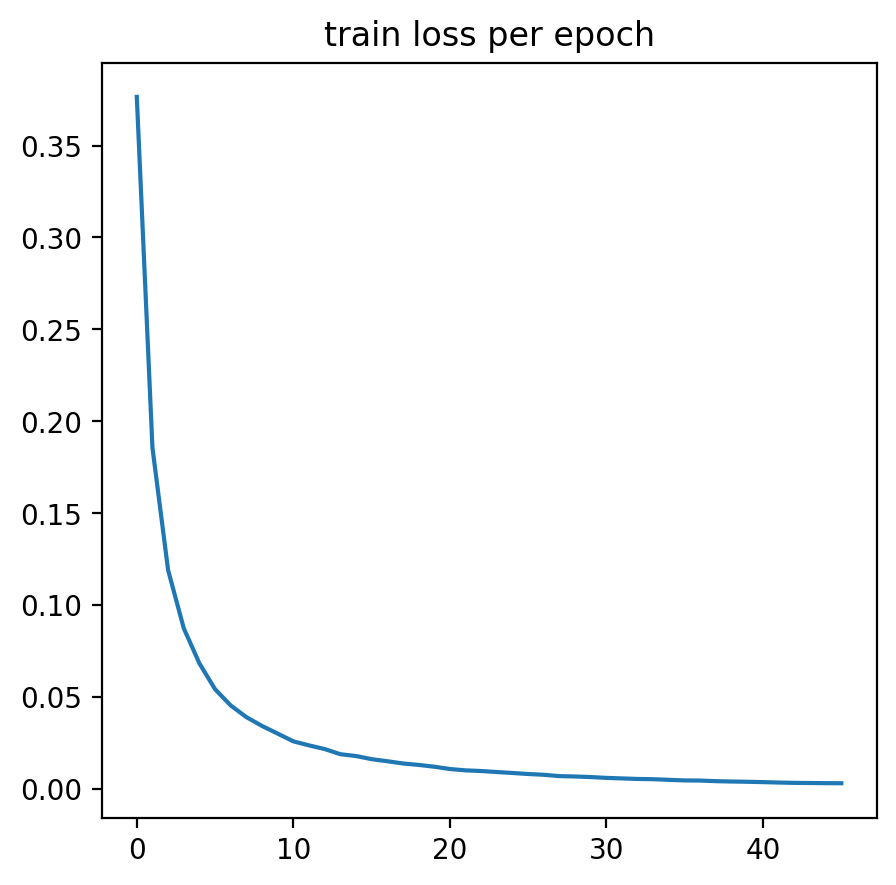

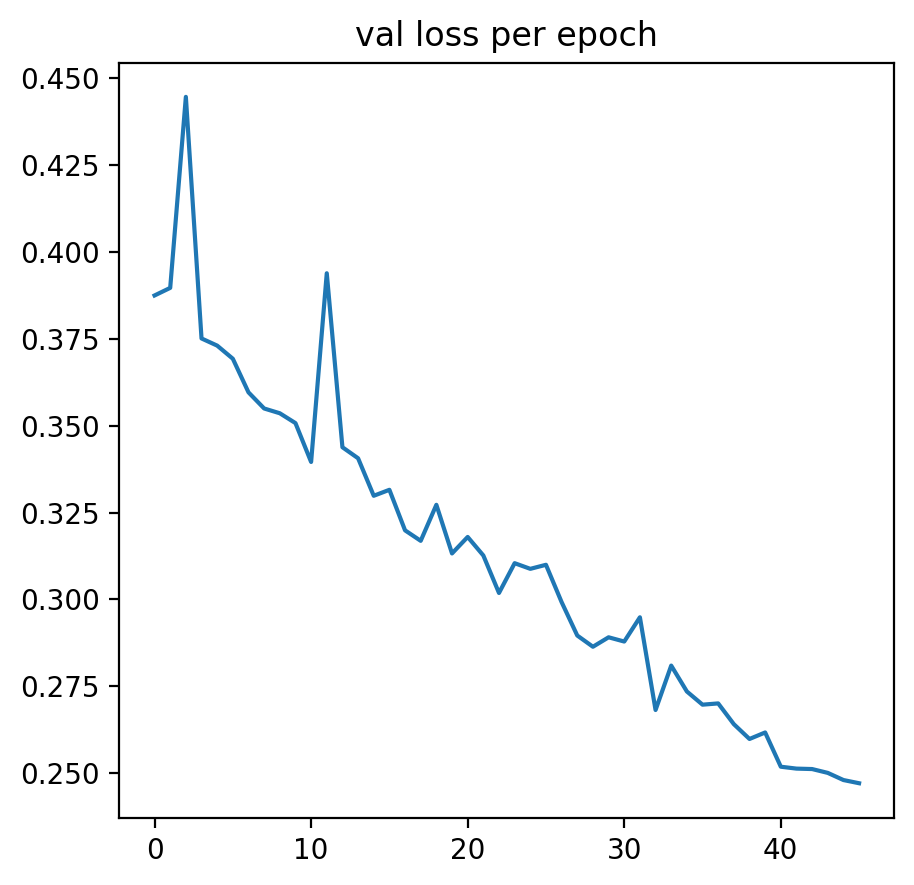

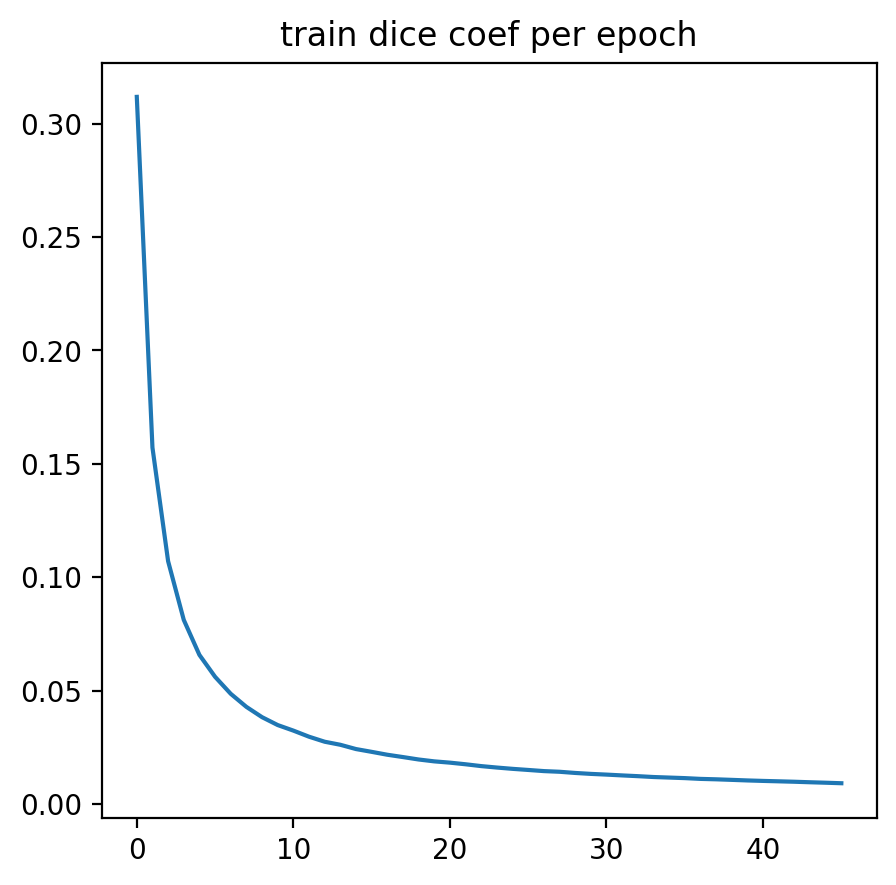

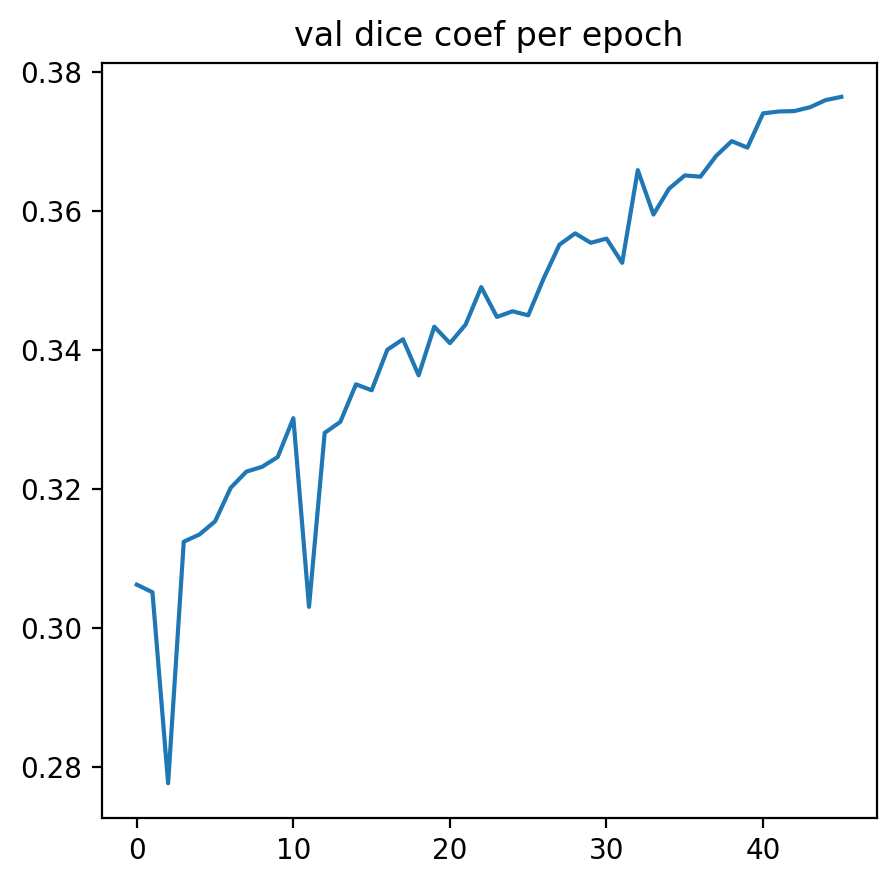

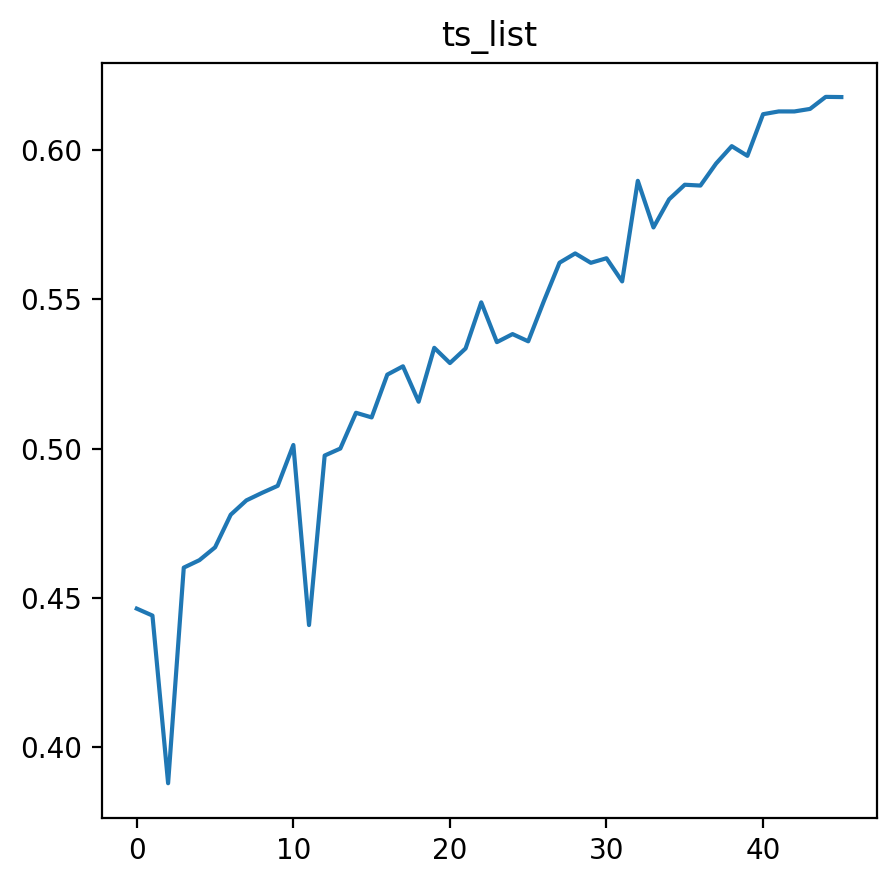

In [14]:
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True)

model, loss_dict, dice_dict, ts_list = tarin_eval_model(my_model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=5, checkpoint_file=None, to_save_path='/scratch/ht1162/DLResult/self_res50_aug_real.pth', 
                     batch_size=1,
                     eval_every = 300)

loading previous weights success
Epoch 1/10
----------
current training loss is 0.146952
current training dice is 0.426524
training iteration 300 takes 43.114967
Current validation loss is 0.247454
Current validation dice is 0.376273
Current validation ts is 0.618142
current val takes 32.17853379249573
saving best model
current training loss is 0.070885
current training dice is 0.214557
training iteration 600 takes 78.667606
Current validation loss is 0.251363
Current validation dice is 0.374318
Current validation ts is 0.611823
current val takes 32.126049518585205
current training loss is 0.045533
current training dice is 0.143900
training iteration 900 takes 77.500135
Current validation loss is 0.244426
Current validation dice is 0.377787
Current validation ts is 0.622185
current val takes 37.30932950973511
saving best model
current training loss is 0.034576
current training dice is 0.107712
training iteration 1200 takes 83.408981
Current validation loss is 0.239231
Current validatio

Current validation loss is 0.203849
Current validation dice is 0.398076
Current validation ts is 0.681393
current val takes 30.10589909553528
saving best model
current training loss is 0.002441
current training dice is 0.013931
training iteration 9900 takes 70.533897
Current validation loss is 0.203254
Current validation dice is 0.398373
Current validation ts is 0.682264
current val takes 36.50978875160217
saving best model
current training loss is 0.002385
current training dice is 0.013514
training iteration 10200 takes 76.816816
Current validation loss is 0.202290
Current validation dice is 0.398855
Current validation ts is 0.683544
current val takes 37.040382623672485
saving best model
current training loss is 0.002169
current training dice is 0.013201
training iteration 10500 takes 81.004689
Current validation loss is 0.204574
Current validation dice is 0.397713
Current validation ts is 0.680124
current val takes 37.54732823371887
current training loss is 0.002153
current training 

current training loss is 0.000778
current training dice is 0.007423
training iteration 19200 takes 79.239321
Current validation loss is 0.169698
Current validation dice is 0.415151
Current validation ts is 0.732879
current val takes 36.26489996910095
saving best model
Epoch 8/10
----------
current training loss is 0.000775
current training dice is 0.007305
training iteration 19500 takes 18.210061
Current validation loss is 0.189332
Current validation dice is 0.405334
Current validation ts is 0.702175
current val takes 31.600757598876953
current training loss is 0.000728
current training dice is 0.007212
training iteration 19800 takes 83.047734
Current validation loss is 0.177966
Current validation dice is 0.411017
Current validation ts is 0.719736
current val takes 29.488656997680664
current training loss is 0.000712
current training dice is 0.007106
training iteration 20100 takes 74.077825
Current validation loss is 0.182685
Current validation dice is 0.408657
Current validation ts is

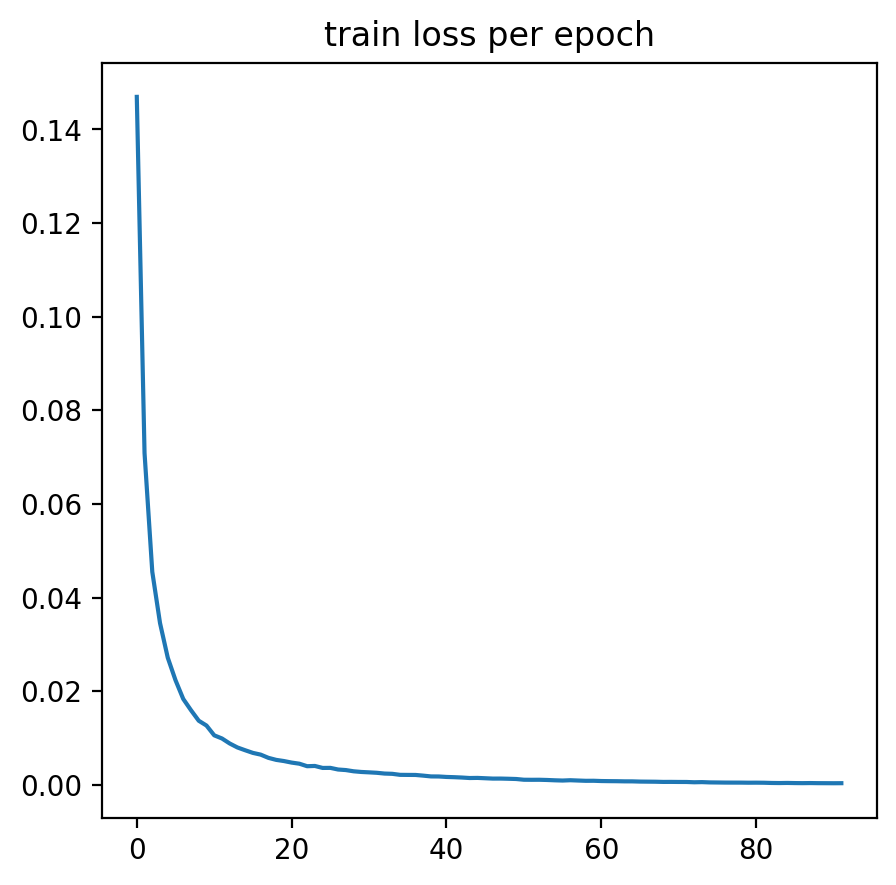

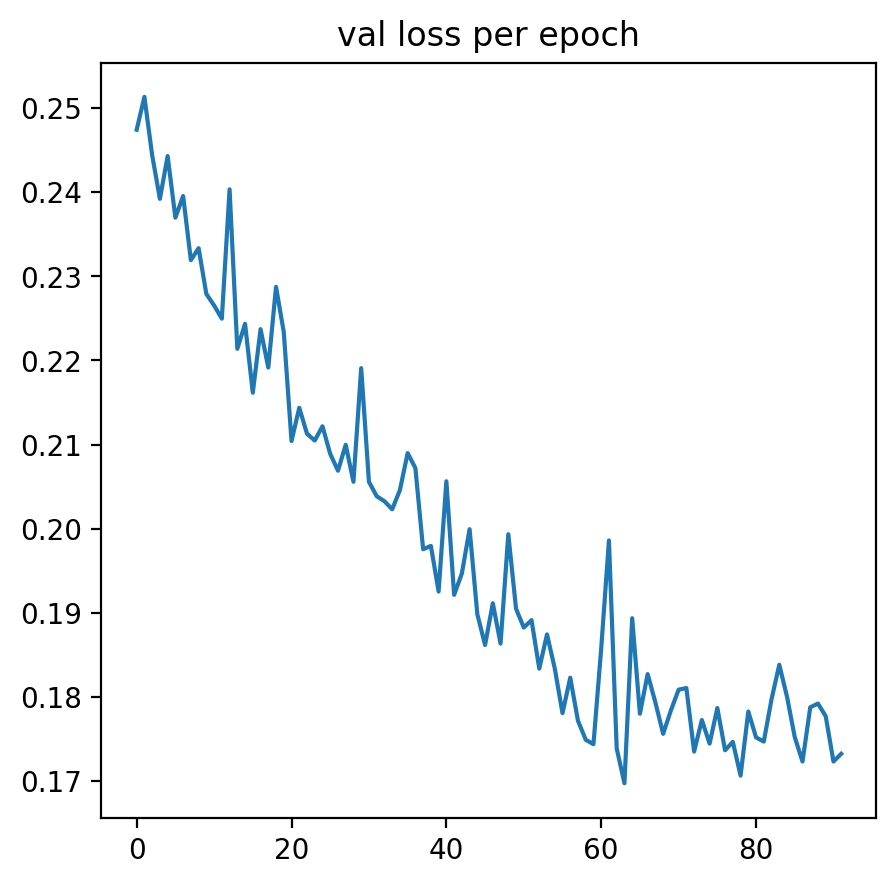

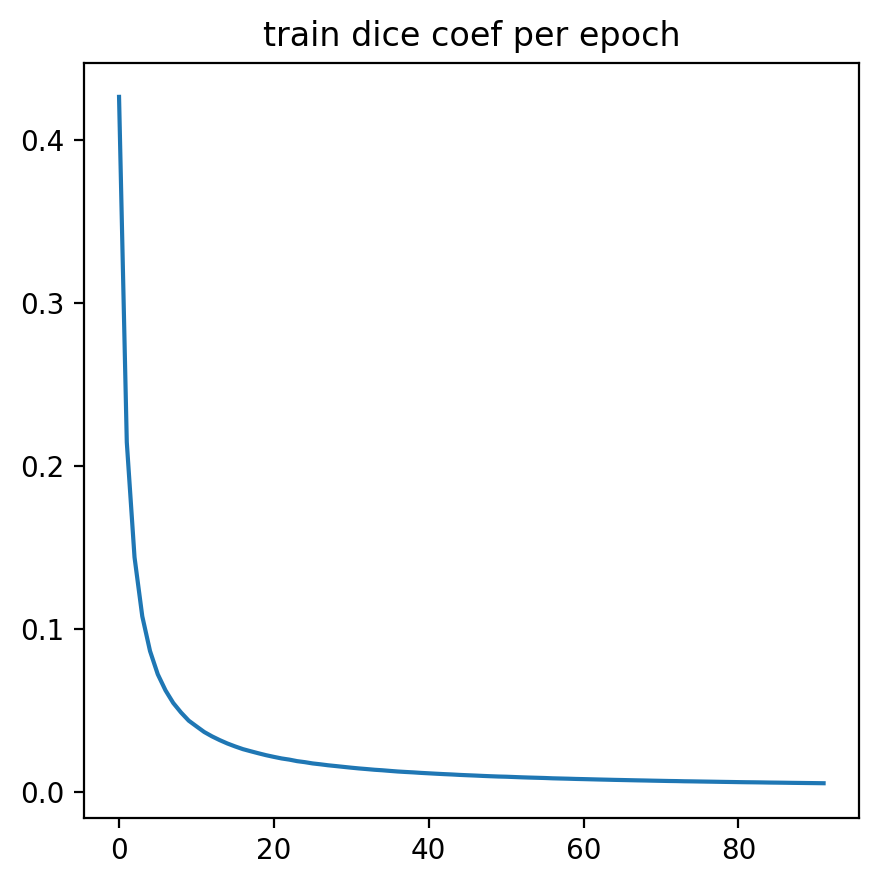

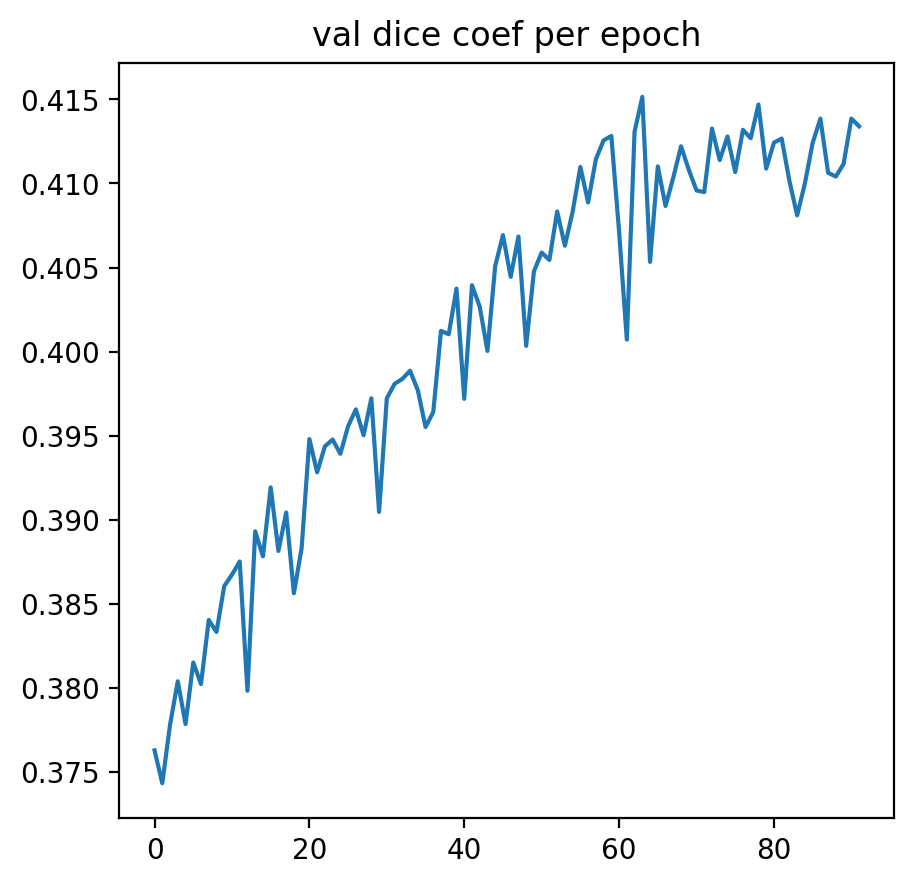

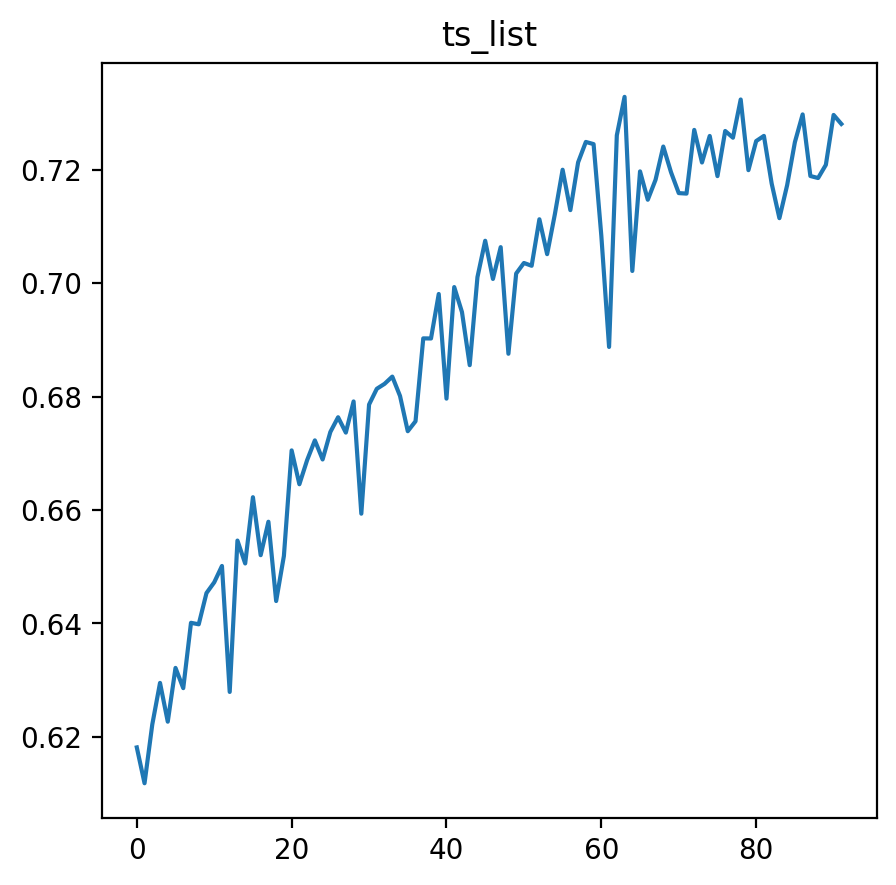

In [15]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=10, checkpoint_file='/scratch/ht1162/DLResult/self_res50_aug_real.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_aug_real.pth', 
                     batch_size=1,
                     eval_every = 300)

In [16]:
model, loss_dict, dice_dict, ts_list = tarin_eval_model(model, train_loader, val_loader, dice_loss, optimizer, 
                     scheduler, num_epochs=3, checkpoint_file='/scratch/ht1162/DLResult/self_res50_aug_real.pth', to_save_path='/scratch/ht1162/DLResult/self_res50_aug_real.pth', 
                     batch_size=1,
                     eval_every = 100)

loading previous weights success
Epoch 1/3
----------
current training loss is 0.048604
current training dice is 0.475698
training iteration 100 takes 14.723891
Current validation loss is 0.176236
Current validation dice is 0.411882
Current validation ts is 0.722848
current val takes 30.069568157196045
current training loss is 0.023834
current training dice is 0.238083
training iteration 200 takes 44.876530
Current validation loss is 0.176304
Current validation dice is 0.411848
Current validation ts is 0.722026
current val takes 33.33699941635132
current training loss is 0.017576
current training dice is 0.157879
training iteration 300 takes 49.310699
Current validation loss is 0.192334
Current validation dice is 0.403833
Current validation ts is 0.698781
current val takes 29.69042658805847
current training loss is 0.012839
current training dice is 0.118581
training iteration 400 takes 44.448120
Epoch   142: reducing learning rate of group 0 to 5.0000e-05.
Current validation loss is 0.

Current validation loss is 0.179984
Current validation dice is 0.410008
Current validation ts is 0.717185
current val takes 35.02108716964722
current training loss is 0.001212
current training dice is 0.014546
training iteration 3300 takes 49.821361
Current validation loss is 0.176055
Current validation dice is 0.411972
Current validation ts is 0.723651
current val takes 35.36902832984924
current training loss is 0.001249
current training dice is 0.014081
training iteration 3400 takes 50.163513
Current validation loss is 0.181652
Current validation dice is 0.409174
Current validation ts is 0.714805
current val takes 28.37012529373169
current training loss is 0.001157
current training dice is 0.013707
training iteration 3500 takes 45.452053
Current validation loss is 0.176040
Current validation dice is 0.411980
Current validation ts is 0.723403
current val takes 31.8436541557312
current training loss is 0.001231
current training dice is 0.013274
training iteration 3600 takes 46.545084
C

KeyboardInterrupt: 